# Entrez Example
## Upstream Regulator Analysis

----------------------

Author: Mikayla Webster (13webstermj@gmail.com)

Date: 26th February, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Load Networks](#load)
6. [TF Enrichment and Activation State Prediction](#pz)
8. [Display Our results](#display)

## Background
<a id='background'></a>

The inspiration for these modules comes from Ingenuity System's [Ingenuity Upstream Regulator Analysis in IPA®](http://pages.ingenuity.com/rs/ingenuity/images/0812%20upstream_regulator_analysis_whitepaper.pdf).

This notebook explains how to use our package using entrez gene labels. The process is almost identical to using gene symbols as labels. Just specify entrex instead of symbol when you instantiate Upstream. This notebook is a derivative of our URA_Arthritis notebook.

## Import packages
<a id='import'></a>

In [1]:
# import upstream regulator module
import sys
code_path = '../../network_bio_toolkit'
sys.path.append(code_path)
import Upstream
reload(Upstream)

<module 'Upstream' from '../../network_bio_toolkit\Upstream.pyc'>

In [2]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

human = 'human'
mouse = 'mouse'

ura = Upstream.Upstream(gene_type = entrez, species = human)

## Load Networks
<a id='load'></a>

1. List of all **Transcription Factors** (TF's) or regulators of interest to us
    <br>
    - Our sources are [slowkow](https://github.com/slowkow/tftargets) and [jaspar](http://jaspar.genereg.net/) TF databases
    <br><br>
2. **Background Network**: [STRING human protein interactions network](https://string-db.org/cgi/download.pl?UserId=9BGA8WkVMRl6&sessionId=HWUK6Dum9xC6&species_text=Homo+sapiens)  
    - Filter our background network down to just the sub network of TF's and their targets
    <br><br>
3. User-supplied list of **Differentially Expressed Genes** (DEG's)

In [3]:
# transcription factors
ura.easy_load_TF_list('../../TF_databases/TF_database_URA.csv')
TF_list = ura.get('TF_list')
print "Number of TF's: " + str(len(TF_list))

../../network_bio_toolkit\create_graph.py:46: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df2 = pd.DataFrame.from_csv(csv_filename)


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-5988...done.
Finished.
813 input query terms found dup hits:
	[(u'HIF3A', 2), (u'PDCD11', 2), (u'EN1', 4), (u'NR0B1', 2), (u'IRX5', 4), (u'IRX4', 3), (u'IRX6', 3)
1520 input query terms found no hit:
	[u'AAANWWTGC', u'AAAYRNCTG', u'AAAYWAACM', u'AACTTT', u'AACWWCAANK', u'AACYNNNNTTCCS', u'AAGWWRNYGGC
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
Number of TF's: 2501


In [4]:
# background network
#filename = "../../background_networks/10090.protein.actions.v10.5.txt"
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
ura.load_STRING_to_digraph(filename, confidence_filter)
DG_TF = ura.get('DG_TF')

print "\nNumber of interactions: " + str(len(list(DG_TF.edges())))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
34 input query terms found dup hits:
	[(u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000313571', 2), (u'ENSP00000368927', 2),
314 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 28795


In [5]:
# differentially expressed genes
# DEG_filename = 'DE_CoeffSaline_2w - Uninjured_Cooke_RNAseq_synovium_20171025.csv'
DEG_filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
ura.create_DEG_list(DEG_filename, p_value_filter = 0.05, fold_change_filter = 1)

DEG_list = ura.get('DEG_list')
print "Number of DEG's: " + str(len(DEG_list))

../../network_bio_toolkit\create_graph.py:366: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  df = pd.DataFrame.from_csv(filename, sep = sep)


Number of DEG's: 1407


## TF Enrichment and Activation State Prediction
<a id='pz'></a>

1. **Enrichment**: How relevant is a TF to its DEG targets? Are they connected by chance, or is their connection statistically significant?
    <br>
    1. -log(p-value) for each TF using [scipy.stats.hypergeom.logsf](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.hypergeom.html).
        1. high value = significant connection between this TF and its DEG targets
        2. low value = TF is randomly associated with its DEG targets
        3. zero = None of this TF's targets were DEG's
        4. inf = original p-value was so small that its log is inf. Very high significance.
        <br><br>
2. **Activation State Prediction**: Goal is to predict the activation states of the TF's

    - activation states: interaction type/regulation direction = predicted state
        - activating/up  = activating
        - activating/down = inhibiting
        - inhibiting/up = inhibiting
        - inhibiting/down = activating
        <br><br>
    - unbiased vs biased calculations:
        - **unbiased calculation**: Assume a normal distribution of activating and inhibiting states 
        - **biased calculation**: For the case when you cannot assume a 50-50 split between up/down-regulated targets and activating/inhbiting interactions. Modify our formula to approximate a normal distribution.

In [6]:
# Enrichment of every TF with respect to its targets
ura.tf_target_enrichment_calc()

# Enrichment of TF's themselves
ura.tf_enrichment_calc()   
ura.get('tf_enrichment')

TF_ENRICHMENT    1.431126e-10
dtype: float64

In [7]:
ura.tf_zscore(bias_filter=0.25)

## Display Our Results
<a id='display'></a>
- Display TF's with top z-scores
- Display a histogram to see where specific genes rank among others according to z-score
- Display subnetwork of a particular TF and its targets

In [8]:
top_values = ura.top_values(act=True, abs_value=True, top=10)
display(top_values)

,z-score,(adj) p-value,(log) fold change
7514,3.152963,0.168758,-0.359554
5519,3.152963,0.611683,-0.177476
5048,2.840188,0.503449,-0.184175
25909,2.672612,0.043968,0.433160
8379,2.672612,0.039497,0.498333
9793,2.672612,0.866232,-0.075115
9184,2.672612,0.045270,-0.537536
1058,2.672612,NaN,NaN
23332,2.672612,0.002788,-0.798831
23122,2.672612,0.024748,-0.451585


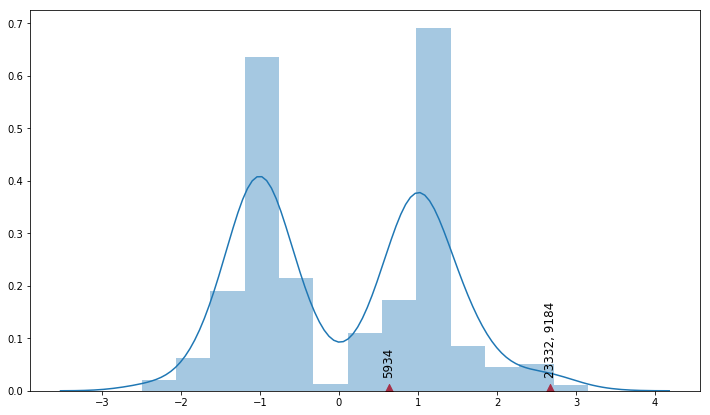

In [9]:
genes_to_rank = ['23332', '9184', '5934']
ura.compare_genes(genes_to_rank)

In [10]:
ura.vis_tf_network('9184',
              directed_edges = True,
              color_non_DEGs=True,
              node_spacing = 2000,
              graph_id = 5,
              tf_size_amplifier = 0) 

In [11]:
# display subnetworks using visJS2jupyter
ura.vis_tf_network('5934',
              color_non_DEGs=True,
              directed_edges = True,
              node_spacing = 2000,
              graph_id = 6,
              tf_size_amplifier = 0) 

In [12]:
# to write data to a csv file
#csv_filename = 'analysis_entrez.txt'
#ura.to_csv(csv_filename)